# NN Learning from neighborhoods

This studycase focuses on linear regression Neural Networks to predict 2-dimensional layouts from network data - a task usually assigned to <b>SOM</b> (Self-Organizing Maps) ; despite the need to feed the model with an fair amount of data and the inevitable doubts about the scalabitily of it, this approach looks promising : it seems to handle <b>discontinuities</b> quite well whereas SOM, which are first designed for continuous representations, may struggle.

The training data here is not exactly Graphs nodes and edges : the model is trained with "neighborhoods", i.e. non-exclusive clusters of nearby locations, but could probably be trained with regular adjacency matrices as well. 
<br>A whole Graph is trained as a unique datapoint, where the ordering of nodes plays a crucial role for the prediction accuracy.

<b>Of course it works because of the way the input data is generated: there is no particular shuffling and no randomness. Data is stacked in the same order as it is produced. On top of that, the use of <i>set()</i> function at some point introduces natural order in the system - which is a problematic. </b>

In [39]:
import numpy as np
import random
import networkx as nx
import math
import itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rc('axes',edgecolor='#AAAAAA',linewidth=2)
matplotlib.rc('grid',color='#CCCCCC')
matplotlib.rc('xtick',labelsize=9)
matplotlib.rc('ytick',labelsize=9)

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model

keras.backend.clear_session()
np.random.seed(43)
tf.random.set_seed(43)

In [40]:
def palette(M):
    range1, range2 = 255./(M.shape[0]-1), 255./(M.shape[1]-1)
    y = np.zeros((M.shape[0],M.shape[1],3))
    for i in range(M.shape[0]):
        for ii in range(M.shape[1]):
            r = i*range1
            g = ii*range2
            b = (M.shape[1]-ii-1)*range2
            color = np.array([r,g,b])
            y[i,ii] = color
    y[y>1.] == 1
    y[y<0.] == 0
    return y

def plotPalette(y, t="Colors are linked to location"):
    plt.figure(figsize=(y.shape[0]*0.35, y.shape[1]*0.35))
    plt.title(t, fontsize=10)
    plt.axis(False)
    plt.imshow(y)
    
def plotPalettes(l, titles, rows=1, cols=1, size=(10,4)):
    for row in range(rows):
        plt.figure(figsize=size)
        for subplot, title, X_red in zip([int(f"1{cols}{i}") for i in range(1,cols+1)], titles[row*cols:(row+1)*cols], l[row*cols:(row+1)*cols]):
            plt.subplot(subplot)
            plt.title(title, fontsize=8)
            plt.axis(False)
            plt.imshow(X_red)
        plt.show()
        
def draw_images(imgs, shape=False, node_order=None, partitions=[], colors=[], titles=[]):
    
    fig = plt.figure(figsize=(10,2))
    ax = plt.gca()
    ax.axis(False)
    
    for i in range(len(imgs)):
        ax1 = fig.add_subplot(1,5,i+1)
        ax1.imshow(imgs[i], cmap="Greys", interpolation="none")    
        plt.title(titles[i], fontsize=8) 
        plt.grid(False)
        plt.axis(False)

    plt.show()    
    plt.close()

## 1. Generate a dataset

### Define the drawing sheet, the surface of representation of the graph nodes

Surface of representation of shape (5, 5) :

[[ 7 11  6 14 25]
 [16  9 13 12  2]
 [10 19  4 24  8]
 [21 15  3 23 20]
 [17 22 18  1  5]]

Each point is labeled with a random number.
Each point is labeled with a gradient color, consistent with the point location.


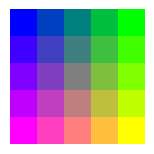

In [41]:
N = 25
R = np.array(range(1,N+1))
np.random.shuffle(R)
M = R.reshape((int(N**0.5),int(N**0.5)))

colors = palette(M)
colorsMap = colors.reshape((M.ravel().shape[0],3))
labelsMap = M.ravel().tolist() # from 1 to 25

print (f"Surface of representation of shape {M.shape} :")
print ("")
print (M)
print ("")
print ("Each point is labeled with a random number.")
plotPalette(colors/255., t="")
print ("Each point is labeled with a gradient color, consistent with the point location.")

### Generate filters of missing pixels

In [42]:
pixels_missing = 5

# How many possibilities ?
base_set = N
subset = N-pixels_missing
comb = math.comb(base_set, subset)

print (f"full set length = {base_set}")
print (f"subset length = {subset}")
print (f"possibilities =", comb)

full set length = 25
subset length = 20
possibilities = 53130


Filters = 20000 (37.64 % of the maximum)


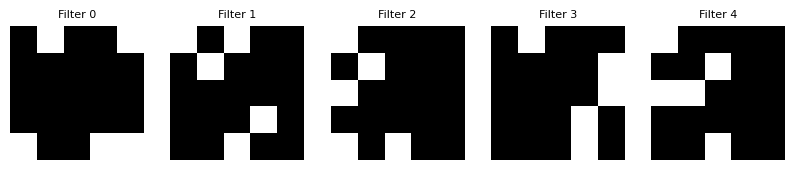

In [44]:
N_filters = 20000

shapes = []
Template = np.ones(M.shape).astype(bool)

for drop_idx in itertools.combinations(range(N), pixels_missing):
    Shape = Template.copy()
    for ii in range(len(drop_idx)):
        Shape[drop_idx[ii]//int(N**0.5), drop_idx[ii]%int(N**0.5)] = 0
    shapes.append(Shape)
    
shapes = shapes[:N_filters]
random.shuffle(shapes)

print (f"Filters = {len(shapes)} ({round(len(shapes)*100/comb, 2)} % of the maximum)")
draw_images(shapes[0:5], titles=[f"Filter {a}" for a in range(5)])

### Apply the filters to the original surface, generate clusters, shuffle

In [6]:
def getGroups(Shape, tile=(2,2)):
    groups = []
    for i in range(Shape.shape[0]-tile[0]+1):
        for ii in range(Shape.shape[1]-tile[0]+1):
            mask = Shape[i:i+tile[0],ii:ii+tile[1]]
            chunk = M[i:i+tile[0],ii:ii+tile[1]]
            if len(chunk[mask].ravel().tolist())>0:
                groups.append(chunk[mask].ravel().tolist())
    return groups

tile = (2,2)

dataset = []
for shape in shapes:
    groups = getGroups(shape, tile=tile)
    random.shuffle([random.shuffle(group) for group in groups])
    dataset.append(groups)

print (f"Items in dataset : {len(dataset)}")
print (f"Item sample      : {dataset[0]}")

Items in dataset : 20000
Item sample      : [[7, 11], [6, 11], [12, 6, 14], [25, 12, 14], [19, 10], [4, 19], [24, 4, 12], [12, 24, 8], [10, 19, 15], [3, 15, 4, 19], [3, 23, 24, 4], [24, 20, 8, 23], [22, 15, 17], [18, 15, 22, 3], [18, 23, 3, 1], [23, 5, 1, 20]]


### Worth to note that :
- The clusters reflect the affinity of each pixel according to location : they are <b>neighborhoods</b> ;
- Clusters are <b>overlapping</b> and not mutually exclusive ;
- Shuffling is mandatory in order to <b>prevent knowledge transfer</b> ;
- <b>Data augmentation</b> is possible and very straightforward.

## 2. Data preparation

In [7]:
import pic
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=3)

def reorder(clusters, method=False):
    intersections = np.zeros((len(clusters),len(clusters))).astype(int)
    for i in range(len(clusters)):
        for ii in range(len(clusters)):
            #if i!=ii:
            s1 = set(clusters[i])
            s2 = set(clusters[ii])
            intersections[i,ii] = len(s1.intersection(s2))
    
    if method=="PIC":
        v = pic.pic(intersections, 10000, 1.0e-2)
        order = np.argsort(v.ravel()).tolist()[0]
        
    elif method=="MAX":
        order = []
        for i in range(intersections.shape[0]):
            idx = np.argsort(intersections[i])[::-1]
            for ind in idx:
                if ind not in order:
                    order.append(ind)
                    break

    else:
        order = list(range(len(clusters)))

    return [sorted(clusters[order[i]]) for i in range(len(order))]

def getGroupMatrix(groups, nodes):
    rows = len(nodes)
    cols = len(groups)
    arr = np.zeros((rows,cols)).astype(float)
    
    for i in range(rows):
        for ii in range(cols):
            if nodes[i] in groups[ii]:
                arr[i,ii] += 1
    # Normalize
    arr_norm = arr / np.sum(arr, axis=1)[:, None]
    return arr_norm

def getLocations(shape):
    indexes = np.argwhere(shape)
    return indexes
    
def node_2_index(node_list):
    indexes = []
    for node in node_list:
        indexes.append(np.argwhere(M==node)[0])
    return [indexes]

In [22]:
tt_split = N_filters-200
features = int((N**0.5)-1)**2

X, y_shape, y_node = [], [], []

for groups in dataset[:tt_split]:
    
    temp = groups.copy()
    
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
    # Data Preparation - reordering
    
    # clusters : different ordering methods can be chosen (see adjacency matrices)
    groups = reorder(groups, method="PIC")
    
    # nodes :    the set() function will sort the nodes in natural order
    # careful with that, since we don't know about the "names", just about the relations...
    nodes_duplicates = [node for group in groups for node in group]
    nodes = []
    [nodes.append(node) for node in nodes_duplicates if node not in nodes]
    
    # if "names" are consistent across all groups, then
    nodes = list(set([node for group in groups for node in group]))

    arr = getGroupMatrix(groups, nodes)
    if arr.shape[1] < features:
        arr = np.hstack((arr, np.zeros((arr.shape[0], features - arr.shape[1]))))
    arr = arr.ravel()

    node_specific_locations = np.array(node_2_index(nodes)).ravel()
    shape_specific_locations = getLocations(shapes[dataset.index(temp)]).ravel()
    del temp

    X.append(arr)
    y_shape.append(shape_specific_locations)
    y_node.append(node_specific_locations)
    
X, y_shape, y_node = np.array(X), np.array(y_shape), np.array(y_node)

print (f"Dataset array        : {X.shape}")
print (f"Target array (nodes) : {y_node.shape}")
print (f"Target array (shape) : {y_shape.shape}")

Dataset array        : (19800, 320)
Target array (nodes) : (19800, 40)
Target array (shape) : (19800, 40)


## 3. Model definition and training

In [23]:
def Model():

    keras.backend.clear_session()

    model = keras.models.Sequential([
        keras.Input(((N-pixels_missing)*features,)),
        keras.layers.Dense(1000, activation="leaky_relu"),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(400, activation="leaky_relu"),
        keras.layers.Dense(200, activation="leaky_relu"),
        keras.layers.Dense(40, activation="leaky_relu"),
        keras.layers.Dense((N-pixels_missing)*2)
    ])

    model.compile(
        loss="mean_squared_error", 
        #loss="MeanAbsoluteError",
        #loss="KLDivergence",
        #loss="categorical_crossentropy",
        #loss="SparseCategoricalCrossentropy",
        #optimizer=keras.optimizers.SGD(learning_rate=2e-3),
        optimizer=keras.optimizers.Adam(learning_rate=5e-4),
        #optimizer=keras.optimizers.Adagrad(learning_rate=1e-2),
        #optimizer=keras.optimizers.Adamax(learning_rate=5e-4),
        #optimizer=keras.optimizers.Nadam(learning_rate=1e-3),
        #optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
        metrics=['Accuracy']
    )
    
    return model

earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              min_delta=0.0001, verbose=1,
                                              start_from_epoch=60, patience=5,
                                              restore_best_weights=True)

### Model training, node specific

In [24]:
epochs = 160

X_train, X_valid, y_train, y_valid = train_test_split(X, y_node, 
                                                      test_size=0.2, random_state=42)
model_node = Model()

history = model_node.fit(
        X_train, y_train, 
        epochs=epochs, 
        callbacks=[earlystopping],
        validation_data=(X_valid, y_valid)
)

model_node.save("models/240922_node.keras")
model_node.save_weights("models/240922_node.weights.h5")

Epoch 1/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - Accuracy: 0.1240 - loss: 1.6800 - val_Accuracy: 0.1957 - val_loss: 0.6934
Epoch 2/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1456 - loss: 0.6411 - val_Accuracy: 0.1048 - val_loss: 0.4673
Epoch 3/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1188 - loss: 0.4489 - val_Accuracy: 0.0891 - val_loss: 0.3567
Epoch 4/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1353 - loss: 0.3535 - val_Accuracy: 0.1455 - val_loss: 0.2969
Epoch 5/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1463 - loss: 0.2936 - val_Accuracy: 0.1139 - val_loss: 0.2597
Epoch 6/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1431 - loss: 0.2549 - val_Accuracy: 0.0914 - val_loss: 0.2297
Epoch 7/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1359 - loss: 0.2256 - val_Accuracy: 0.1194 - val_loss: 0.2085
Epoch 8/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - Accuracy: 0.1362 - loss: 0.2017 - 

495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1176 - loss: 0.0230 - val_Accuracy: 0.1508 - val_loss: 0.0510
Epoch 100/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1143 - loss: 0.0226 - val_Accuracy: 0.1182 - val_loss: 0.0515
Epoch 101/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1090 - loss: 0.0229 - val_Accuracy: 0.2033 - val_loss: 0.0510
Epoch 102/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1078 - loss: 0.0227 - val_Accuracy: 0.1477 - val_loss: 0.0507
Epoch 103/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1120 - loss: 0.0220 - val_Accuracy: 0.3174 - val_loss: 0.0506
Epoch 104/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1159 - loss: 0.0222 - val_Accuracy: 0.1159 - val_loss: 0.0500
Epoch 105/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1124 - loss: 0.0218 - val_Accuracy: 0.2710 - val_loss: 0.0497
Epoch 106/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1146 - loss: 0.0215 

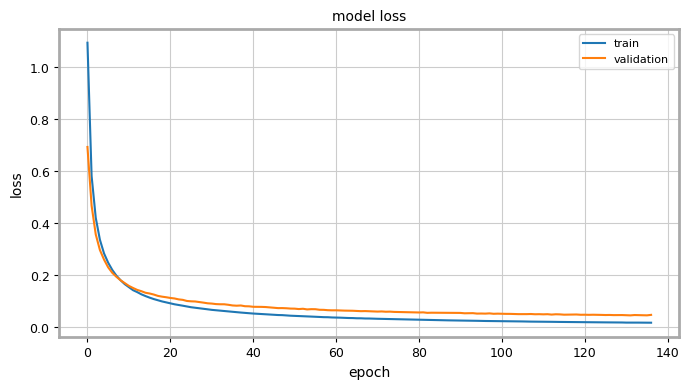

In [26]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=10)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

### Model training, shape specific

In [27]:
epochs = 160

X_train, X_valid, y_train, y_valid = train_test_split(X, y_shape, 
                                                      test_size=0.2, random_state=42)
model_shape = Model()

history = model_shape.fit(
        X_train, y_train, 
        epochs=epochs, 
        callbacks=[earlystopping],
        validation_data=(X_valid, y_valid)
)

model_shape.save("models/240922_shape.keras")
model_shape.save_weights("models/240922_shape.weights.h5")

Epoch 1/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - Accuracy: 8.4033e-04 - loss: 1.5201 - val_Accuracy: 0.0000e+00 - val_loss: 0.7336
Epoch 2/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - Accuracy: 5.4011e-05 - loss: 0.7182 - val_Accuracy: 0.0000e+00 - val_loss: 0.6581
Epoch 3/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - Accuracy: 4.0753e-04 - loss: 0.6340 - val_Accuracy: 0.0020 - val_loss: 0.6023
Epoch 4/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Accuracy: 0.0021 - loss: 0.5699 - val_Accuracy: 0.0086 - val_loss: 0.5634
Epoch 5/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Accuracy: 0.0069 - loss: 0.5175 - val_Accuracy: 0.0255 - val_loss: 0.5205
Epoch 6/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Accuracy: 0.0238 - loss: 0.4707 - val_Accuracy: 0.0316 - val_loss: 0.4967
Epoch 7/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Accuracy: 0.0404 - loss: 0.4275 - val_Accuracy: 0.0369 - val_loss: 0.4648
Epoch 8/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - Accuracy: 0.0487 - los

Epoch 51/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.1996 - loss: 0.0711 - val_Accuracy: 0.1225 - val_loss: 0.2685
Epoch 52/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2051 - loss: 0.0706 - val_Accuracy: 0.1273 - val_loss: 0.2588
Epoch 53/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2020 - loss: 0.0693 - val_Accuracy: 0.1199 - val_loss: 0.2641
Epoch 54/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2064 - loss: 0.0694 - val_Accuracy: 0.1245 - val_loss: 0.2646
Epoch 55/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2083 - loss: 0.0675 - val_Accuracy: 0.1374 - val_loss: 0.2663
Epoch 56/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2015 - loss: 0.0658 - val_Accuracy: 0.1235 - val_loss: 0.2679
Epoch 57/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2084 - loss: 0.0656 - val_Accuracy: 0.1086 - val_loss: 0.2635
Epoch 58/160
495/495 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - Accuracy: 0.2042 - loss: 0

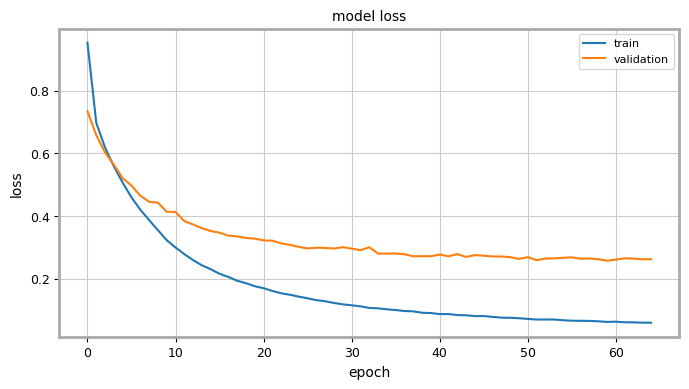

In [28]:
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss', fontsize=10)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right', fontsize=8)
plt.grid(True)
plt.show()

## 4. Results

In [29]:
X_test, y_test_node, y_test_shape = [], [], []
nodes_list = []

for groups in dataset[tt_split:]:
    
    temp = groups.copy()
    groups = reorder(groups, method="PIC")

    nodes = list(set([node for group in groups for node in group]))
    nodes_list.append(nodes)
    
    arr = getGroupMatrix(groups, nodes)
    if arr.shape[1] < features:
        arr = np.hstack((arr, np.zeros((arr.shape[0],features-arr.shape[1]))))
    arr = arr.ravel()

    node_specific_locations = np.array(node_2_index(nodes)).ravel()
    shape_specific_locations = getLocations(shapes[dataset.index(temp)]).ravel()

    X_test.append(arr)
    y_test_shape.append(shape_specific_locations)
    y_test_node.append(node_specific_locations)
    
X_test, y_test_node, y_test_shape = np.array(X_test), np.array(y_test_node).astype(int), np.array(y_test_shape).astype(int)
print (X_test.shape, y_test_node.shape, y_test_shape.shape)

pred_node = model_node.predict(X_test)
pred_shape = model_shape.predict(X_test)

(200, 320) (200, 40) (200, 40)
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [30]:
# node specific

distances = [np.sum(np.abs(pred_node - y_test_node), axis=1)]
max_distance = np.max(np.abs(pred_node - y_test_node))
print ("Average distance prediction-to-label =", np.mean(distances)/(N-pixels_missing))
print ("Maximal distance =", max_distance)
print (f"Success rate = {np.sum(np.abs(pred_node - y_test_node)<0.5)} / {y_test_node.ravel().shape[0]} ({round(np.sum(np.abs(pred_node - y_test_node)<0.5)*100 / y_test_node.ravel().shape[0],2)} %)")

Average distance prediction-to-label = 0.22441567233996468
Maximal distance = 3.452122688293457
Success rate = 7738 / 8000 (96.72 %)


In [31]:
# shape specific

distances = [np.sum(np.abs(pred_shape - y_test_shape), axis=1)]
max_distance = np.max(np.abs(pred_shape - y_test_shape))
print ("Average distance prediction-to-label =", np.mean(distances)/(N-pixels_missing))
print ("Maximal distance =", max_distance)
print (f"Success rate = {np.sum(np.abs(pred_shape - y_test_shape)<0.5)} / {y_test_shape.ravel().shape[0]} ({round(np.sum(np.abs(pred_shape - y_test_shape)<0.5)*100 / y_test_shape.ravel().shape[0],2)} %)")

Average distance prediction-to-label = 0.4566006304534894
Maximal distance = 4.16561222076416
Success rate = 7024 / 8000 (87.8 %)


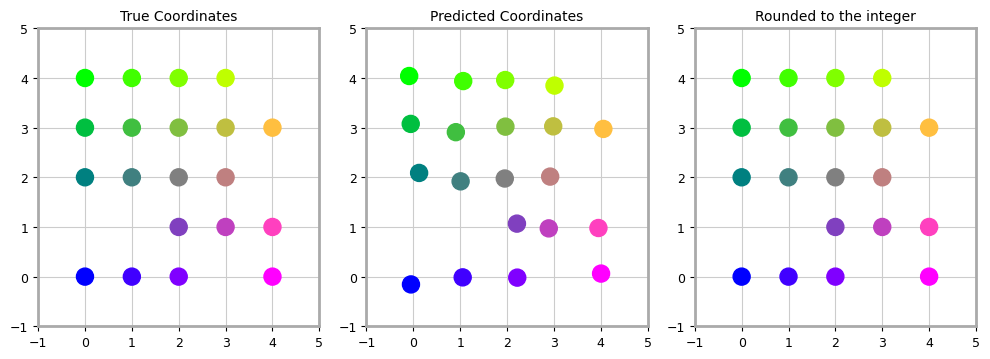

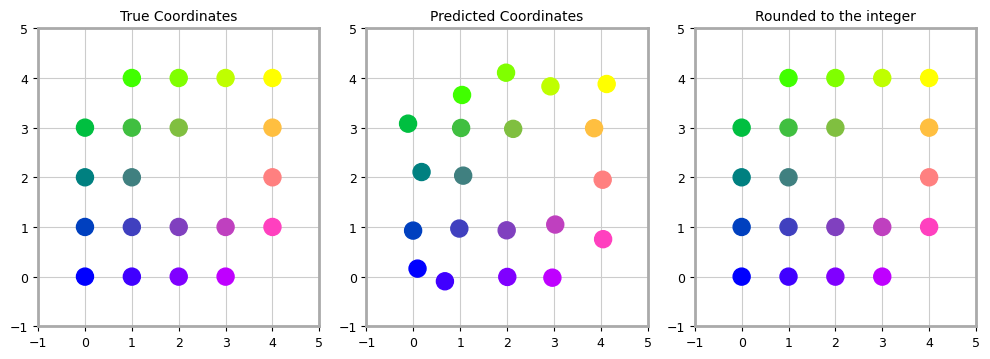

In [32]:
def plot_results(true_coords, pred_coords, edge_index):
    
    true_coords = np.array(true_coords)
    pred_coords = np.array(pred_coords)
    
    cmap = [colors[a[0],a[1]]/255. for a in true_coords.T.astype(int)]
    
    plt.figure(figsize=(10, 3.7))

    ax = plt.subplot(1, 3, 1)
    ax.set_xlim([-1, 5])
    ax.set_ylim([-1, 5])
    plt.scatter(true_coords[0, :], true_coords[1, :], 
                c=cmap, label='True (x, y)', s=150, zorder=2)
    plt.title('True Coordinates', fontsize=10)
    plt.grid(True)

    ax = plt.subplot(1, 3, 2)
    ax.set_xlim([-1, 5])
    ax.set_ylim([-1, 5])
    plt.scatter(pred_coords[0, :], pred_coords[1, :], 
                c=cmap, label='Predicted (x, y)', s=150, zorder=2)
    plt.title('Predicted Coordinates', fontsize=10)
    plt.grid(True)
    
    ax = plt.subplot(1, 3, 3)
    ax.set_xlim([-1, 5])
    ax.set_ylim([-1, 5])
    plt.scatter(np.round(pred_coords[0, :]), np.round(pred_coords[1, :]), 
                c=cmap, label='Predicted (x, y)', s=150, zorder=2)
    plt.title('Rounded to the integer', fontsize=10)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

display = 4
plot_results([y_test_node[display][::2],y_test_node[display][1::2]], [pred_node[display][::2],pred_node[display][1::2]], [])

display = 7
plot_results([y_test_node[display][::2],y_test_node[display][1::2]], [pred_node[display][::2],pred_node[display][1::2]], [])

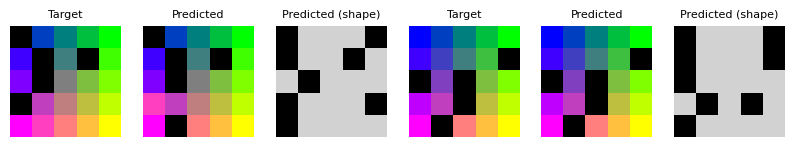

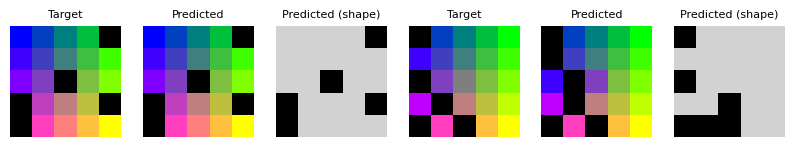

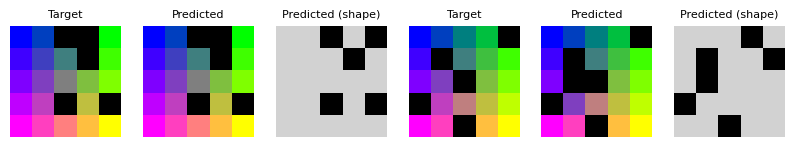

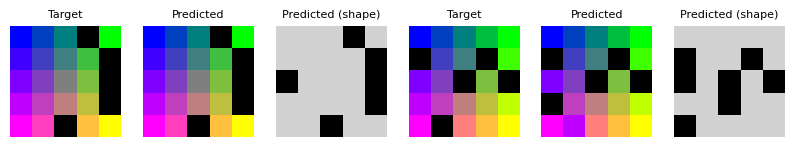

In [33]:
images, titles = [], []

for i in range(32,48):    
    cols = []
    for node in nodes_list[i]:
        col_idx = labelsMap.index(node)
        cols.append(colorsMap[col_idx])
    
    im1 = np.zeros((M.shape[0],M.shape[1],3))
    testX, testY = y_test_node[i][::2], y_test_node[i][1::2]
    im1[testX, testY] = cols
    
    pred_node[i][pred_node[i]>(N**0.5)-1] = (N**0.5)-1
    im2 = np.zeros((M.shape[0],M.shape[1],3))
    im2[np.round(pred_node[i][::2]).astype(int),np.round(pred_node[i][1::2]).astype(int)] = cols
    
    pred_shape[i][pred_shape[i]>(N**0.5)-1] = (N**0.5)-1
    im3 = np.zeros((M.shape[0],M.shape[1],3))
    im3[np.round(pred_shape[i][::2]).astype(int),np.round(pred_shape[i][1::2]).astype(int)] = 210
  
    images += [im1/255., im2/255., im3/255.]
    titles += ["Target", "Predicted", "Predicted (shape)"]

for i in range(0,8,2):
    plotPalettes(images[i*3:(i+2)*3], titles[i*3:(i+2)*3], 
                 rows=1, cols=6, size=(10,4))

## 5. Conclusive statements
- This simple neural model can predict the location of items based on their relations to other items (edges) with quite some accuracy - with that respect they offer a <b>possible alternative to self-organizing maps</b> which struggle to <b>express discontinuities</b> ;
- As a Supervised Learning model, its accuracy partly relies on the amount of data - a greater generalization would likely imply a <b>larger training set</b> ;
- <b>Nodes re-ordering</b> is key to the model performance.

## 6. Further research
- How efficient is <b>data augmentation</b> here ?
- Can the model be trained with a <b>reduced set of images</b> in the manner of a "shape grammar" ?
- Is PIC reordering more efficient than other <b>re-ordering methods</b> ?
- Is it possible to train the model with varying amounts of "missing pixels" or is it specific ?
- How does the model react to <b>"noise"</b> and complex, <b>non-euclidean bindings</b>&nbsp;? Is it suitable for <b>Graph representations</b> ? 
- This approach has to be compared to <b>SOM</b> and <b>Autoencoders</b> techniques.